### Source
https://github.com/jeffheaton/app_deep_learning/blob/854a0e4a3982daea4e50d34e4d8fc0d9d806b960/t81_558_class_04_1_kfold.ipynb

In [2]:
from IPython.display import Image

### Using K-Fold Cross-validation with PyTorch
You can use cross-validation for a variety of purposes in predictive modeling:

- Generating out-of-sample prediction from a neural network
- Estimate a good number of epochs to train a neural network (early stopping)
- Evaluate the effectiveness of certain hyperparameters, such as activation functions, neuron counts, and layer counts

Cross-validation uses several folds and multiple models to provide each data segment a chance to serve as both the validation and training set.

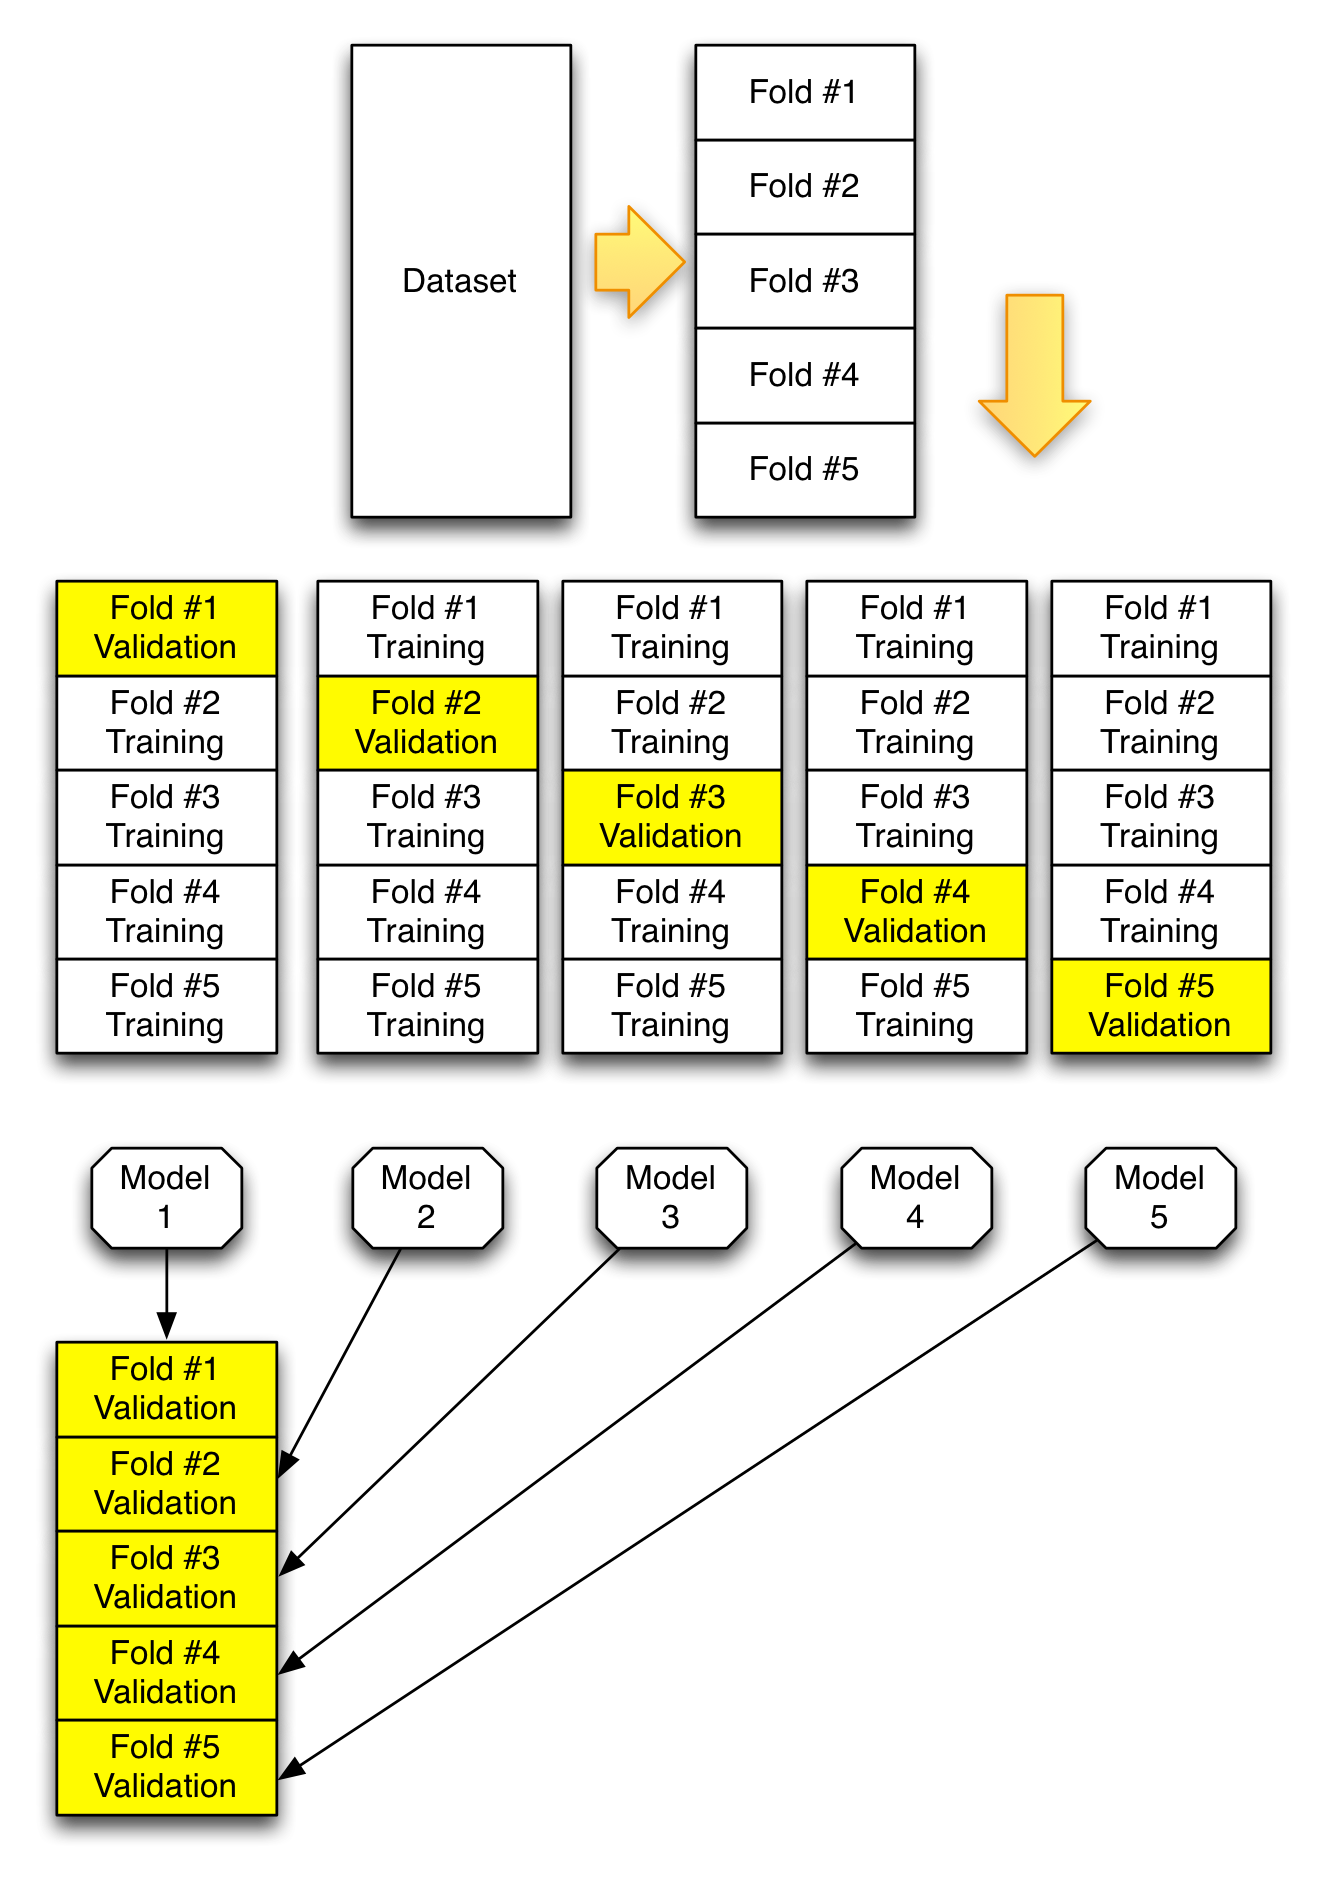

In [3]:
Image("images/kfolds.png")

It is important to note that each fold will have one model (neural network). To generate prediction for new data (not present in the training set), predictions from the fold models can be handled in several ways:

- Choose the model with the highest validation score as the final model.
- Preset new data to the five models (one for each fold) and average the result (this is an ensemble).
- Retrain a new model (using the same settings as the cross-validation) on the entire dataset. Train for as many epochs and with the same hidden layer structure.

Generally, its preferred the last approach and will retrain a model on the entire data set once I have selected hyper-parameters. Of course, its preferred to set aside a final holdout set for model validation that it's not used in any aspect of the training process.

In [15]:
# Early stopping
import copy
device = "cpu"
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
        
    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement found in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

### Regression vs Classification K-Fold Cross-Validation
Regression and classification are handled somewhat differently concerning cross-validation. Regression is the simpler case where you can break up the data set into k folds with little regard for where each item lands. For regression, the data items should fall into the folds as randomly as possible. It is also important to remember that to every fold will necessarily have the same number of data items. It is nota always possible for the dataset to be evenly divided into K folds for regression cross-validation, we will use Scikit-Learn class KFold. 

Cross-validation for classification could also use the KFold object; however this technique would not ensure that the class balance remains the same in each fold as in the original. The balance of classes that a model was trained on must remain the same (or similar) to the training set. Drift in this distribution is one of the most important things to monitor after a trained model has been  placed into actual use. Because of this, we wanto to make sure that the cross-validation itself does not introduce an unintended shift. This technique is called statified sampling and is accomplished by using the Scikit-Learn object StratifiedKFold in place of KFold whenever you use classification. In summary, you should use the following two objects in Scikit-Learn:

- KFold when dealing with a regression problem
- StratifiedKFold When dealing with a classification problem

The following two sections demonstrate cross-validation with classification and regression.

### Out-of-Sample Regression predictions with K-Fold Cross-Validation
The following code trains the simple dataset using a 5-fold cross-validation. The expected performance of a neural network of the type trained here would be the score for the generated out-of-sample predictions. We begin by preparing a feature vector using the jh-simple-dataset to predict age. This model is set up as a regression problem.

In [2]:
import pandas as pd
from scipy.stats import zscore

In [3]:
def fill_na_with_median(df):
    """
    Replace all na values in numeric fields with median 
    """
    for col in df.columns:
        if df[col].dtype in ['float32', 'int32', 'int64', 'float64', 'long']:
            median = df[col].median()
            df[col].fillna(median, inplace=True)
    return df

def load_dataset(route):
    df = pd.read_csv(route, na_values=["NA", "?"])
    df = fill_na_with_median(df)
    return df

df = load_dataset("data/jh-simple-dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2000 non-null   int64  
 1   job             2000 non-null   object 
 2   area            2000 non-null   object 
 3   income          2000 non-null   float64
 4   aspect          2000 non-null   float64
 5   subscriptions   2000 non-null   int64  
 6   dist_healthy    2000 non-null   float64
 7   save_rate       2000 non-null   int64  
 8   dist_unhealthy  2000 non-null   float64
 9   age             2000 non-null   int64  
 10  pop_dense       2000 non-null   float64
 11  retail_dense    2000 non-null   float64
 12  crime           2000 non-null   float64
 13  product         2000 non-null   object 
dtypes: float64(7), int64(4), object(3)
memory usage: 218.9+ KB


In [4]:
def generate_dummies(df, dummies_list, drop_original=True):
    """Generate dummies for certain categorical columns"""
    for col in dummies_list:
        if df[col].dtype in ['object', 'categories']:
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col, dtype=int)], axis=1)
            if drop_original:
                df.drop(col, axis=1, inplace=True)
    
    return df


dummies_list = ['job', 'area', 'product']            
df = generate_dummies(df, dummies_list)       

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 55 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2000 non-null   int64  
 1   income          2000 non-null   float64
 2   aspect          2000 non-null   float64
 3   subscriptions   2000 non-null   int64  
 4   dist_healthy    2000 non-null   float64
 5   save_rate       2000 non-null   int64  
 6   dist_unhealthy  2000 non-null   float64
 7   age             2000 non-null   int64  
 8   pop_dense       2000 non-null   float64
 9   retail_dense    2000 non-null   float64
 10  crime           2000 non-null   float64
 11  job_11          2000 non-null   int32  
 12  job_al          2000 non-null   int32  
 13  job_am          2000 non-null   int32  
 14  job_ax          2000 non-null   int32  
 15  job_bf          2000 non-null   int32  
 16  job_by          2000 non-null   int32  
 17  job_cv          2000 non-null   i

In [5]:
# standardize ranges
num_fields = ['income', 'aspect', 'save_rate', 'subscriptions']
for field in num_fields:
    df[field] = zscore(df[field])

In [7]:
import torch 
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [8]:
# manual seed
torch.manual_seed(42)

# create pytorch feature tensors of all df fields except 'age' and 'id'
x_columns = df.columns.drop(['age', 'id'])
x = torch.tensor(df[x_columns].values, dtype=torch.float32, device=device)
# .view(-1,1) reshapes 'y' to a column matrix
y = torch.tensor(df['age'].values, dtype=torch.float32, device=device).view(-1,1) 

Now that the feature vector is created a 5-fold cross-validation can be performed to tenerate out-of-sample predictions. We will assume 500 epochs. Later we will see how we can estimate a more optimal epoch count.

In [19]:
# Cross-Validate
kf = KFold(n_splits=6, shuffle=True, random_state=42)
for ti, tsi in kf.split(x):
    print(ti.shape, ti.shape)

(1666,) (1666,)
(1666,) (1666,)
(1667,) (1667,)
(1667,) (1667,)
(1667,) (1667,)
(1667,) (1667,)


In [15]:
# early stopping parameters
patience = 10

fold = 0
for train_index, test_index in kf.split(x):
    fold += 1
    print(f"Fold #{fold}")
    
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Load Dataset in PyTorch
    train_ds = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    
    # sequential model
    model = nn.Sequential(
        nn.Linear(x.shape[1], 20), 
        nn.ReLU(),
        nn.Linear(20,10),
        nn.ReLU(),
        nn.Linear(10,1)
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    
    # early stopping variables
    best_loss = float('inf')
    early_stopping_counter = 0
    
    # training loops
    epochs = 500
    epoch = 0
    done = False
    early_stop = EarlyStopping()
    
    while not done and epoch < epochs:
        epoch += 1
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            
        # validation
        model.eval()
        with torch.no_grad():
            val_output = model(x_test)
            val_loss = loss_fn(val_output, y_test)
        
        if early_stop(model, val_loss):
            done = True
            
    print(f"Epoch {epoch}/{epochs}, Validation Loss: "
          f"{val_loss.item()}, {early_stop.status}")
    
# final evaluation
model.eval()
with torch.no_grad():
    oos_pred = model(x_test)
score = torch.sqrt(loss_fn(oos_pred, y_test)).item()
print(f"Fold score (rmse: {score}")
        

Fold #1
Epoch 118/500, Validation Loss: 0.7491408586502075, Early stopping triggered after 5 epochs
Fold #2
Epoch 178/500, Validation Loss: 0.31753358244895935, Early stopping triggered after 5 epochs
Fold #3
Epoch 169/500, Validation Loss: 0.680805504322052, Early stopping triggered after 5 epochs
Fold #4
Epoch 137/500, Validation Loss: 0.6700904369354248, Early stopping triggered after 5 epochs
Fold #5
Epoch 112/500, Validation Loss: 0.9619856476783752, Early stopping triggered after 5 epochs
Fold score (smse: 0.9780293107032776


As it can be seen, the above code also reports the average number of epochs needed. A common technique is to then train on the entire dataset for the average number of epochs required.

### Classification with Stratified K-Fold Cross-Validation

The following code trains and fits the jh-simple-dataset with cross-validation to generate out-of-sample. It also writes the out-of-sample (predictions on the test set) results.

It is good to perform statified k-fold cross-validation with cassification data. This technique ensuere that the percentages of each class remain the same across all folds. 

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import zscore
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [10]:
def fill_na_with_median(df):
    """
    Replace all na values in numeric fields with median 
    """
    for col in df.columns:
        if df[col].dtype in ['float32', 'int32', 'int64', 'float64', 'long']:
            median = df[col].median()
            df[col].fillna(median, inplace=True)
    return df

def load_dataset(route):
    df = pd.read_csv(route, na_values=["NA", "?"])
    df = fill_na_with_median(df)
    return df

df = load_dataset("data/jh-simple-dataset.csv")

def generate_dummies(df, dummies_list, drop_original=True):
    """Generate dummies for certain categorical columns"""
    for col in dummies_list:
        if df[col].dtype in ['object', 'categories']:
            df = pd.concat([df, pd.get_dummies(df[col], prefix=col, dtype=int)], axis=1)
            if drop_original:
                df.drop(col, axis=1, inplace=True)
    
    return df

dummies_list = ['job', 'area']            
df = generate_dummies(df, dummies_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 49 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2000 non-null   int64  
 1   income          2000 non-null   float64
 2   aspect          2000 non-null   float64
 3   subscriptions   2000 non-null   int64  
 4   dist_healthy    2000 non-null   float64
 5   save_rate       2000 non-null   int64  
 6   dist_unhealthy  2000 non-null   float64
 7   age             2000 non-null   int64  
 8   pop_dense       2000 non-null   float64
 9   retail_dense    2000 non-null   float64
 10  crime           2000 non-null   float64
 11  product         2000 non-null   object 
 12  job_11          2000 non-null   int32  
 13  job_al          2000 non-null   int32  
 14  job_am          2000 non-null   int32  
 15  job_ax          2000 non-null   int32  
 16  job_bf          2000 non-null   int32  
 17  job_by          2000 non-null   i

In [11]:
# standardize ranges
num_fields = ['income', 'aspect', 'save_rate', 'age', 'subscriptions']
for field in num_fields:
    df[field] = zscore(df[field])

In [12]:
# create features x fields
x_columns = df.columns.drop(['product', 'id'])
x = df[x_columns].values

# create categorical y fields
y_cat = pd.get_dummies(df['product'], dtype=int)
products = y_cat.columns
y = y_cat.values

We now loop through the five folds and use the validation data in each fold for early stopping. We also keep the validated predictions across the entire dataset that were not in the training data. It is important to note that this separation is not 100% pure in that the validation set was used for early stopping. This small crossover is a tradeoff that allows us to use a large amount of training data in each fold.

In [13]:
# data as np array
x = np.array(x)
y = np.array(y)

device = "cpu"

# sequential model
model = nn.Sequential(
    nn.Linear(x.shape[1], 50),
    nn.ReLU(),
    nn.Linear(50, 25),
    nn.ReLU(),
    nn.Linear(25, y.shape[1]),
    nn.Softmax(dim=1)
).to(device)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# defining loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# training loop
oos_y = []
oss_pred = []
fold = 0

for train, test in kf.split(x, df['product']):
    fold += 1
    print(f"Fold #{fold}")
    
    x_train = torch.tensor(x[train], dtype=torch.float32, device=device)
    y_train = torch.tensor(np.argmax(y[train], axis=1), dtype=torch.long, device=device)
    x_test = torch.tensor(x[test], dtype=torch.float32, device=device)
    y_test = torch.tensor(np.argmax(y[test], axis=1), dtype=torch.long, device=device)
    
    # training loop
    epochs = 100
    epoch = 0
    done = False
    
    early_stop = EarlyStopping(restore_best_weights=True)
    while not done and epoch < epochs:
        epoch += 1
        model.train()
        optimizer.zero_grad()
        output = model(x_train).flatten()
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        
        # evaluate validation loss
        model.eval()
        with torch.no_grad():
            y_val = model(x_test).flatten()
            val_loss = criterion(y_val, y_test)
        if early_stop(model, val_loss):
            done = True
    
    # prediction
    with torch.no_grad():
        y_val = model(x_test).flatten()
        _, pred = torch.max(y_val, 1)
    oos_y.append(y_test.item())
    oss_pred.append(pred.item())
    
    print(f"Epoch {epoch}/{epochs}, Validation Loss: {val_loss.item()}, {early_stop.status}")
    
    # measure this fold's accurary
    score = metrics.accuracy_score(y_test.item(), pred.item())
    print(f"Fold score (accuracy): {score}")

# build the oss prediction list and calculate the error
oos_y = np.concatenate(oos_y)
oss_pred = np.concatenate(oss_pred)

score = metrics.accuracy_score(oos_y, oss_pred)
print(f"Fold score (accuracy): {score}")

Fold #1


RuntimeError: size mismatch (got input: [11200], target: [1600])